In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from bs4 import BeautifulSoup
from urllib.request import urlopen
import datetime

# Functions

In [2]:
def get_close(tickers,
              start=datetime.date(datetime.date.today().year - 1, 
                datetime.date.today().month, 
                datetime.date.today().day)
                ,end=datetime.date.today()):
    
    data=pd.DataFrame()
    for ticker in tickers:

        try:

            yahoo_data=yf.Ticker(ticker)
            stock_price=yahoo_data.history(start=start,end=end,interval='1d').reset_index()
            stock_price['Date']=stock_price['Date'].dt.tz_localize(None)
            stock_price=stock_price.set_index('Date')
            stock_price[ticker]=stock_price['Close']+stock_price['Dividends'].shift(periods=-1)
            data=pd.concat([data,stock_price[ticker]],axis=1)

        except Exception as e:
            pass
        
    return data

In [3]:
def get_mrat(dataframe,numerator=21,denominator=200):

    mrat=(dataframe.rolling(numerator).mean()/dataframe.rolling(denominator).mean())
    mrat_wo_na=mrat.dropna(how='all')

    month_end=pd.to_datetime(mrat_wo_na.index)
    mrat_weights=mrat_wo_na.iloc[month_end.is_month_end].copy().fillna(0)

    mrat_weights['Total']=mrat_weights.sum(axis=1)

    for col in mrat_weights.columns:
        mrat_weights[col]=mrat_weights[col]/mrat_weights['Total']

    mrat_weights=mrat_weights.drop(columns='Total')
    mrat_weights_dict=mrat_weights.transpose().to_dict()

    #dates=list(dataframe.index)
    dates_end=list(mrat_weights.index)
    dates_end.insert(0,dataframe.index[0])
    
    return mrat_weights,dates_end

In [4]:
def get_portfolios(mrat_weights,dates_end,numbers_of_stocks=50,
                   investment_amount=10000,
                   transaction_fee=0.005,weight_dict=None):
    tracking={}
    portfolio={}
    initial_amount=investment_amount
    
    for i in range(len(dates_end)-1):

        print(dates_end[i],investment_amount,investment_amount/initial_amount)

        temp=dataframe.loc[dates_end[i]:dates_end[i+1]].copy()
        initial_price=temp.iloc[0].to_dict()

        if dates_end[i]>dates_end[0]:

            top50=mrat_weights.loc[dates_end[i]].sort_values(ascending=False)[:numbers_of_stocks]
            top_50_rebased=top50/top50.sum()
            top_50_dict=top_50_rebased.to_dict()

            weight_dict={}

            for key in temp.columns:

                if key in top_50_dict: 
                    weight_dict[key]=top_50_dict[key]
                else:
                    weight_dict[key]=0

        inital_investment_per_stock={}
        shares={}

        for col in temp.columns:

            inital_investment_per_stock[col]=weight_dict[col]*investment_amount
            shares[col]=inital_investment_per_stock[col]*(1-transaction_fee)/initial_price[col]

        tracking[i]=(weight_dict,shares,investment_amount,initial_price)

        temp=temp*shares    
        portfolio[dates_end[i]]=temp
        investment_amount=temp.iloc[-1].sum()
        
        
    return portfolio,tracking


In [5]:
def get_pnl(portfolios):

    pnl={}

    keys=list(portfolio.keys())
    for i in range(len(keys)):

        if i>0:
            pnl[keys[i]]=portfolio[keys[i]].iloc[-1]-portfolio[keys[i]].iloc[0]

        else:
            
            pnl[keys[0]]=portfolio[keys[0]].iloc[-1]-portfolio[keys[0]].iloc[0]
    
    pnl_dataframe=pd.DataFrame(pnl).cumsum(axis=1).T
    
    return pnl_dataframe

# Dataset

In [24]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
table = pd.read_html(url)
df = table[0]
tickers=df['Symbol'].tolist()

end_date = datetime.datetime.now().strftime("%Y-%m-%d")
#start_date = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")

start_date ="2015-1-1"
analysis_start_date = (datetime.datetime.now() - datetime.timedelta(days=365*4)).strftime("%Y-%m-%d")

dataframe=get_close(tickers,start=start_date,end=end_date)
dataframe.index=pd.to_datetime(dataframe.index)

Got error from yahoo api for ticker BRK.B, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- BRK.B: No timezone found, symbol may be delisted
BF.B: No data found for this date range, symbol may be delisted


In [30]:
sp500=get_close(['SPY'],start=start_date,end=end_date)

# Analysis

In [32]:
weight_dict={col: 1/dataframe.shape[1] for col in dataframe.columns}

mrat_weights,dates_end=get_mrat(dataframe,numerator=21,denominator=200)

portfolio,tracking=get_portfolios(mrat_weights,dates_end,numbers_of_stocks=20,
                   investment_amount=10000,
                   transaction_fee=0.005,weight_dict=weight_dict)

2015-01-02 00:00:00 10000 1.0
2015-11-30 00:00:00 9890.371330756181 0.9890371330756181
2015-12-31 00:00:00 9699.393653374484 0.9699393653374484
2016-02-29 00:00:00 8939.350401243748 0.8939350401243747
2016-03-31 00:00:00 9451.541007799098 0.9451541007799098
2016-05-31 00:00:00 9808.563849108994 0.9808563849108994
2016-06-30 00:00:00 10215.868994354332 1.0215868994354331
2016-08-31 00:00:00 10518.303924568503 1.0518303924568504
2016-09-30 00:00:00 10723.177731369593 1.0723177731369593
2016-10-31 00:00:00 10293.020636089455 1.0293020636089456
2016-11-30 00:00:00 11179.638616328366 1.1179638616328367
2017-01-31 00:00:00 11902.129338749935 1.1902129338749936
2017-02-28 00:00:00 12504.742845766737 1.2504742845766736
2017-03-31 00:00:00 12447.941231275927 1.2447941231275927
2017-05-31 00:00:00 12864.157245086519 1.2864157245086518
2017-06-30 00:00:00 12503.431197124994 1.2503431197124995
2017-07-31 00:00:00 12889.170766220042 1.2889170766220042
2017-08-31 00:00:00 13625.0784394284 1.36250784

In [33]:
investment_amount=1000
shares={}
for col in dataframe:
    
    shares[col]=(weight_dict[col]*investment_amount)/dataframe.iloc[0][col]

In [34]:
equal_weight=shares*dataframe

In [35]:
pnl=get_pnl(portfolio)
pnl['Total']=pnl.sum(axis=1)
pnl_pct=pnl.copy()

for col in pnl_pct.columns:
    pnl_pct[col]/=pnl_pct['Total']
    
pnl_contrib=pd.DataFrame(pnl_pct.iloc[-1].sort_values(ascending=False))
pnl_amount=pd.DataFrame(pnl.iloc[-1].sort_values(ascending=False))


In [36]:
pnl_contrib

,2024-07-31
Total,1.000000
SMCI,0.104194
NVDA,0.102850
VST,0.066135
ENPH,0.049767
...,...
TDG,-0.005738
NCLH,-0.007072
WDC,-0.007148
CCL,-0.016786


<AxesSubplot:>

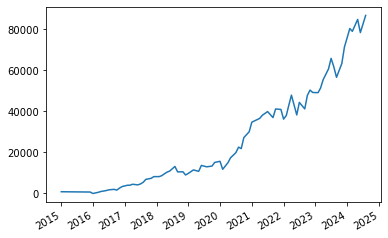

In [37]:
pnl['Total'].plot()

In [38]:
historical_portfolio=pd.DataFrame()
performance=pd.DataFrame()
for key in portfolio.keys():
    historical_portfolio=historical_portfolio.combine_first(portfolio[key])
    

<AxesSubplot:>

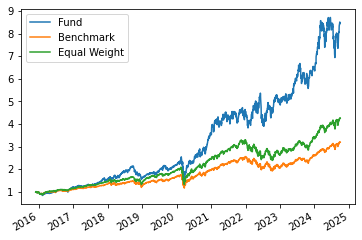

In [39]:
performance['Fund']=historical_portfolio.sum(axis=1)
performance['Benchmark']=sp500
performance['Equal Weight']=equal_weight.sum(axis=1)
performance_pct=performance.copy()
performance_pct=performance_pct.pct_change()

(1+performance_pct.loc[dates_end[1]:]).cumprod().plot()

In [42]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['Benchmark']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['Benchmark'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-1]/performance['Fund'].iloc[0]-1
metrics['Bench Return']=performance['Benchmark'].iloc[-1]/performance['Benchmark'].iloc[0]-1
metrics['Sharpe Ratio']=metrics['Fund Return']/metrics['Fund Vol']

In [43]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.169818
Fund Vol,0.255318
Bench Vol,0.178349
Fund Return,8.035038
Bench Return,2.313205
Sharpe Ratio,31.470681


# Manual Testing

In [18]:
initial_price=dataframe.iloc[0].to_dict()
weight_dict={}
inital_investment_per_stock={}
shares={}
initial_amount=10000

for col in dataframe.columns:
    weight_dict[col]=1/dataframe.shape[1]
    inital_investment_per_stock[col]=weight_dict[col]*initial_amount
    shares[col]=inital_investment_per_stock[col]*(1-0.005)/initial_price[col]

t=(dataframe*shares).sum(axis=1).loc[dates_end[1]]
t

13786.731130425163

In [19]:
top50=mrat_weights.loc[dates_end[1]].sort_values(ascending=False)[:20].round(4)
top_50_rebased=top50/top50.sum()
top_50_rebased=top_50_rebased.to_dict()

inital_investment_per_stock={}
initial_investment=t
shares={}
initial_price=dataframe.loc[dates_end[1]].to_dict()

for col in dataframe.columns:
    
    weight_dict={}
    
    if col in top_50_rebased:
        
        weight_dict[col]=top_50_rebased[col]
    else:
        weight_dict[col]=0
        
    inital_investment_per_stock[col]=weight_dict[col]*initial_investment
    shares[col]=inital_investment_per_stock[col]*(1-0.005)/initial_price[col]

(dataframe*shares).loc[dates_end[2]].sum()

12810.373150754878